# Credit Scoring


В рамках проекта необходимо разработать модель, предсказывающую вероятность дефолта по кредиту на основании имеющихся анкетных данных и данных об итогах уже выданных кредитов.

Для начала импортируем нужные нам библиотеки:


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
import statsmodels.api as sm
import scipy.stats as sst
import warnings
from datetime import datetime
import plotly.express as px
from pandas import Series


from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor 


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import operator

%matplotlib inline

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
!pip freeze > requirements.txt
RANDOM_SEED = 42
CURRENT_DATE = datetime.now()

**Информация о датасете:**

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [3]:
data_directory = '/kaggle/input/sf-dst-scoring/'
data_train = pd.read_csv(data_directory+'train.csv')
data_test = pd.read_csv(data_directory+'test.csv')
sample_submission = pd.read_csv(data_directory+'/sample_submission.csv')

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [5]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

Мы наблюдаем определенное количество пропусков к графе education, значит будем разбираться. 
Для удобства работы объеденим датасеты в один.

In [6]:

data_train['Train'] = 1 
data_test['Train'] = 0 

data = data_train.append(data_test, sort=False).reset_index(drop=True) 

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [8]:
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

Видим 478 пропусков в education, которые надо заполнить. На пропуске в default пока не обращаем внимание, так как это целевая переменная.
Поскольку от общего числа пропусков совсем немного, заменим их на моду:


In [9]:
data.education = data.education.fillna(data.education.mode()[0])

In [10]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
64676,82868,31MAR2014,GRD,M,28,N,N,0,0,-0.634234,2,50,1,1,22000,1,3,N,1.0,1
106589,20213,27JAN2014,SCH,F,46,N,N,2,0,-2.300305,2,60,2,3,40000,3,1,N,NaN,0
24092,7430,14JAN2014,SCH,M,23,N,N,0,0,-2.329506,1,50,1,1,10000,2,1,N,0.0,1
15366,3188,09JAN2014,SCH,F,34,N,N,0,0,-1.752432,4,40,2,3,20000,1,4,N,0.0,1
61114,56195,05MAR2014,SCH,M,45,Y,Y,0,0,-2.441162,0,50,1,2,15000,1,4,N,0.0,1


Также мы замечаем, что столбец app_date содержит информацию о датах, а значит с ним можно поработать в формате datetime:

In [11]:
data['app_date'] = pd.to_datetime(data.app_date, format='%d%b%Y')

In [12]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
25302,83758,2014-03-31,SCH,M,33,Y,N,0,0,-2.310740,0,80,2,3,55000,1,1,N,0.0,1
28201,51685,2014-02-28,UGR,F,24,N,N,0,1,-1.501751,1,80,2,3,35000,2,2,N,1.0,1
70343,77068,2014-03-25,SCH,F,55,N,N,0,0,-1.052950,0,50,1,2,15000,1,4,N,0.0,1
40423,100807,2014-04-17,UGR,F,55,N,N,0,0,-1.996646,4,50,1,2,19000,1,3,N,0.0,1
43908,54937,2014-03-04,SCH,M,45,N,N,0,0,-2.072004,0,50,1,1,20000,1,1,N,0.0,1


# ПРЕДВАРИТЕЛЬНЫЙ АНАЛИЗ ДАННЫХ

In [13]:
data.describe()


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,Train
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,73799.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.126994,0.669999
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.332968,0.470215
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


In [14]:
data.describe(include = 'object')

,education,sex,car,car_type,foreign_passport
count,110148,110148,110148,110148,110148
unique,5,2,2,2,2
top,SCH,F,N,N,N
freq,58476,61836,74290,89140,93721


Из описания мы видим много интересных вещей,но пока не будем заострять на этом внимание.
Переведем признаки типа object в цифровые:

In [15]:
label_encoder = LabelEncoder()

for column in ['education', 'sex', 'car', 'car_type', 'foreign_passport']:
    data[column] = label_encoder.fit_transform(data[column])

In [16]:
data.sample(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
137,66342,2014-03-15,3,1,51,0,0,0,1,-1.880173,2,80,2,2,30000,1,4,1,0.0,1
8945,781,2014-01-04,3,0,57,0,0,1,1,-1.454712,2,80,1,1,30000,1,4,0,0.0,1
49561,68349,2014-03-17,3,0,65,1,0,0,0,-2.315224,3,50,2,3,12000,4,1,0,0.0,1
26943,20287,2014-01-27,1,0,47,1,0,0,0,-1.804798,2,60,1,2,50000,2,3,1,0.0,1
81463,42572,2014-02-19,3,1,25,0,0,2,0,-1.675699,4,60,2,3,35000,3,1,0,NaN,0
41022,25785,2014-02-01,3,0,41,0,0,0,0,-1.707708,3,50,1,1,25000,3,3,0,0.0,1
21777,18215,2014-01-25,1,1,29,0,0,0,0,-2.468756,3,50,1,1,25000,1,3,0,0.0,1
48497,95285,2014-04-11,3,1,28,1,1,0,0,-2.273970,8,70,1,1,50000,1,3,0,0.0,1
90266,101744,2014-04-18,3,0,41,0,0,0,0,-2.887679,1,60,2,3,20000,1,3,1,NaN,0
16149,62668,2014-03-12,1,1,30,1,1,0,0,-2.531171,0,50,2,3,60000,1,4,1,0.0,1


Теперь можно разобраться с датами. По опыту работы можно предположить, что для многих моделей очень важно время, поэтому создадим признак временной дельты от конца 2020 года (будь он неладен!)

In [17]:
data['day'] = data['app_date'].dt.day
data['month'] = data['app_date'].dt.month

In [18]:
NY_2020 = pd.to_datetime('31/12/2020')

In [19]:
data['delta_time'] = (NY_2020 - data['app_date']).dt.days
data[data.month == 1]['delta_time'].head()

3     2534
9     2547
12    2549
15    2535
16    2527
Name: delta_time, dtype: int64

Также мы можем сгенерировать столбец с количеством дней от старта заявки:

In [20]:
start_tr = data.app_date.min()
end_tr = data.app_date.max()
start_tr,end_tr

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [21]:
data['day_num'] = data.app_date - data.app_date.min()
data['day_num'] = data['day_num'].apply(lambda x: str(x).split()[0])
data['day_num'] = data['day_num'].astype(int)

In [22]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,default,Train,day,month,delta_time,day_num
0,25905,2014-02-01,3,1,62,1,1,0,0,-2.008753,...,18000,4,1,0,0.0,1,1,2,2525,31
1,63161,2014-03-12,3,0,59,0,0,0,0,-1.532276,...,19000,4,1,0,0.0,1,12,3,2486,70
2,25887,2014-02-01,3,1,25,1,0,2,0,-1.408142,...,30000,1,4,1,0.0,1,1,2,2525,31
3,16222,2014-01-23,3,0,53,0,0,0,0,-2.057471,...,10000,1,3,0,0.0,1,23,1,2534,22
4,101655,2014-04-18,1,1,48,0,0,0,1,-1.244723,...,30000,1,4,1,0.0,1,18,4,2449,107


Отлично, теперь удаляем ненужные столбцы:

In [23]:
data.drop(['day', 'app_date', 'month'],  axis = 1, inplace = True)

In [24]:
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,delta_time,day_num
0,25905,3,1,62,1,1,0,0,-2.008753,1,...,1,2,18000,4,1,0,0.0,1,2525,31
1,63161,3,0,59,0,0,0,0,-1.532276,3,...,2,3,19000,4,1,0,0.0,1,2486,70
2,25887,3,1,25,1,0,2,0,-1.408142,1,...,1,2,30000,1,4,1,0.0,1,2525,31
3,16222,3,0,53,0,0,0,0,-2.057471,2,...,2,3,10000,1,3,0,0.0,1,2534,22
4,101655,1,1,48,0,0,0,1,-1.244723,1,...,2,3,30000,1,4,1,0.0,1,2449,107


In [25]:
#Посмотрим количество уникальных значений в столбцах
for col in data.columns:
    print('В столбце {0} {1} уникальных значений'.format(col, len(data[col].unique())))

В столбце client_id 110148 уникальных значений
В столбце education 5 уникальных значений
В столбце sex 2 уникальных значений
В столбце age 52 уникальных значений
В столбце car 2 уникальных значений
В столбце car_type 2 уникальных значений
В столбце decline_app_cnt 24 уникальных значений
В столбце good_work 2 уникальных значений
В столбце score_bki 102618 уникальных значений
В столбце bki_request_cnt 40 уникальных значений
В столбце region_rating 7 уникальных значений
В столбце home_address 3 уникальных значений
В столбце work_address 3 уникальных значений
В столбце income 1207 уникальных значений
В столбце sna 4 уникальных значений
В столбце first_time 4 уникальных значений
В столбце foreign_passport 2 уникальных значений
В столбце default 3 уникальных значений
В столбце Train 2 уникальных значений
В столбце delta_time 120 уникальных значений
В столбце day_num 120 уникальных значений


# Разделим данные на группы:

In [26]:
# столбцы default и train не распределяем
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] # бинарные переменные 
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time'] # категориальные переменные
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income','day_num', 'delta_time'] # числовые переменные

# Числовые признаки
Прежде чем начать работу с ними, напишем пару функций:

In [27]:
# Визуализация числовых данных
def viz_num(col, size = 6):
    fig, (g1, g2) = plt.subplots(1, 2, figsize = (2*size,size))
    fig.suptitle('Histogram and boxplot for {0} '.format(col), fontsize=20)
    g1.hist(data[col], bins = 20, histtype = 'bar', align = 'mid', rwidth = 0.8, color = 'blue') # гистограмма
    g2.boxplot(data[col], vert = False)  # выбросы
    plt.figtext(0.5, 0, col, fontsize = 16)
    plt.show

In [28]:
# Статистические данные по выбросам
def statistic(col):
    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    l=perc25 - 1.5*IQR 
    r=perc75 + 1.5*IQR
    print("Для {0} IQR: {1}, ".format(col,IQR),"Границы выбросов: [{0}, {1}].".format(l, r))
    print('Всего {} выбросов'.format(data[data[col] > r][col].count()+data[data[col] < l][col].count()))

**age**

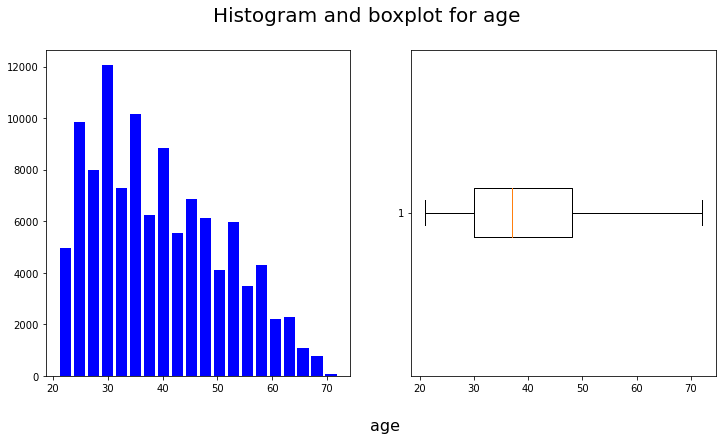

In [29]:
viz_num('age')

Используем логарифмирование и посмотрим на изменения:

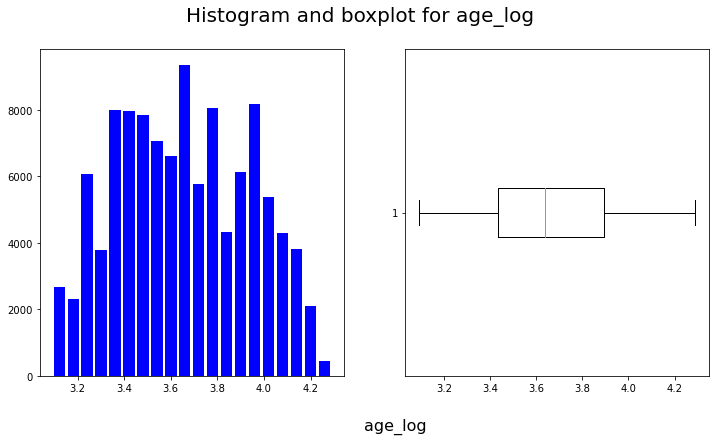

In [30]:
data['age_log'] = np.log(data['age'] + 1)
viz_num('age_log')

Распределение стало ровнее, оставим так

In [31]:
data['age'] = data['age_log']
data.drop(['age_log'], axis = 1, inplace = True)

In [32]:
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,delta_time,day_num
0,25905,3,1,4.143135,1,1,0,0,-2.008753,1,...,1,2,18000,4,1,0,0.0,1,2525,31
1,63161,3,0,4.094345,0,0,0,0,-1.532276,3,...,2,3,19000,4,1,0,0.0,1,2486,70
2,25887,3,1,3.258097,1,0,2,0,-1.408142,1,...,1,2,30000,1,4,1,0.0,1,2525,31
3,16222,3,0,3.988984,0,0,0,0,-2.057471,2,...,2,3,10000,1,3,0,0.0,1,2534,22
4,101655,1,1,3.891820,0,0,0,1,-1.244723,1,...,2,3,30000,1,4,1,0.0,1,2449,107


**decline_app_cnt**

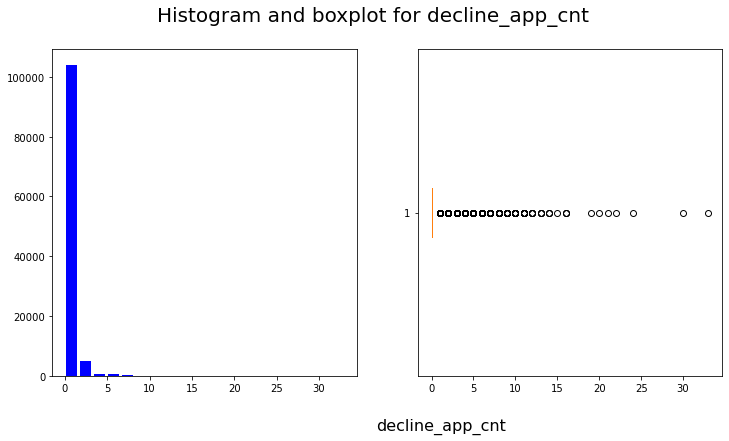

In [33]:
viz_num('decline_app_cnt')

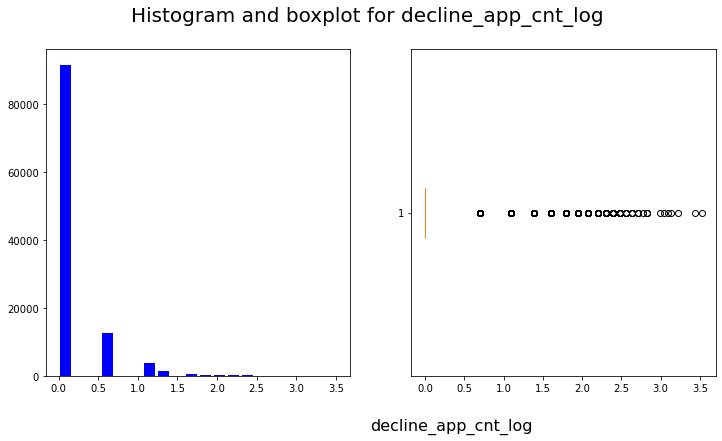

In [34]:
data['decline_app_cnt_log'] = np.log(data['decline_app_cnt'] + 1)
viz_num('decline_app_cnt_log')

Cтало конечно лучше, мы это оставим, но нужно еще посмотреть выбросы:

In [35]:
data['decline_app_cnt'] = data['decline_app_cnt_log']
data.drop(['decline_app_cnt_log'], axis = 1, inplace = True)

Так как в основе данного признака лежит отказ в кредитовании, то можно создать либо бинарный признак был отказ или не был отказ или категориальный признак: не было отказа (0), 1 отказ (1) и 2 и более отказов (2). Исходя из предыдущего анализа добавим бинарный признак

In [36]:
data['decline_yes'] = data['decline_app_cnt'].apply(lambda x: 0 if x < 1 else 1)

In [37]:
bin_cols.append('decline_yes')

**score_bki**

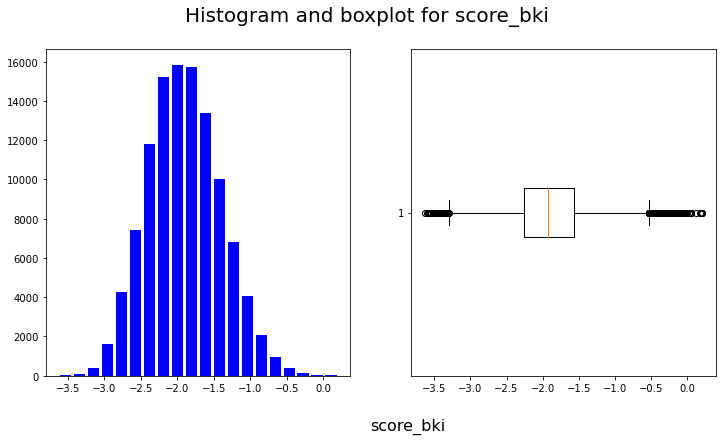

In [38]:
viz_num('score_bki')

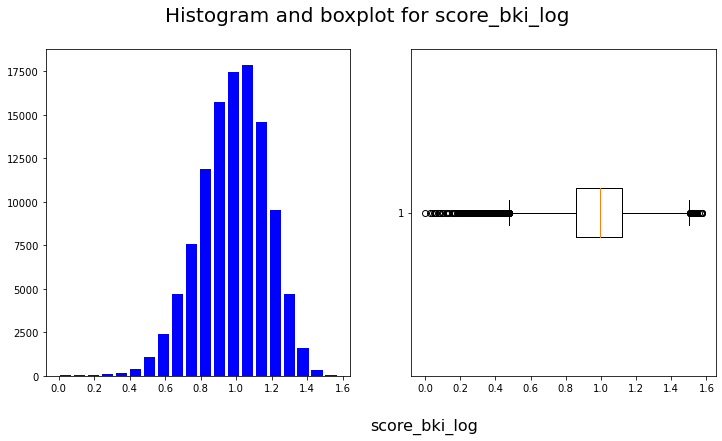

In [39]:
#Для того, чтобы появилась возможность логарифмировать, необходимо сделать данные положительными
data['score_bki'] = data['score_bki'] + abs(data['score_bki'].min())
data['score_bki_log'] = np.log(data['score_bki'] + 1)
viz_num('score_bki_log')

In [40]:
statistic('score_bki')
statistic('score_bki_log')

Для score_bki IQR: 0.6925455175000006,  Границы выбросов: [0.32533437374999896, 3.095516443750001].
Всего 518 выбросов
Для score_bki_log IQR: 0.25691563295687536,  Границы выбросов: [0.4750462207684304, 1.502708752595932].
Всего 712 выбросов


В итоге распределение сильно сместилось, а выбросов даже прибавилось. Поэтому оставляем как есть.

In [41]:
data.drop(['score_bki_log'], axis=1, inplace=True)

**bki_request_cnt**

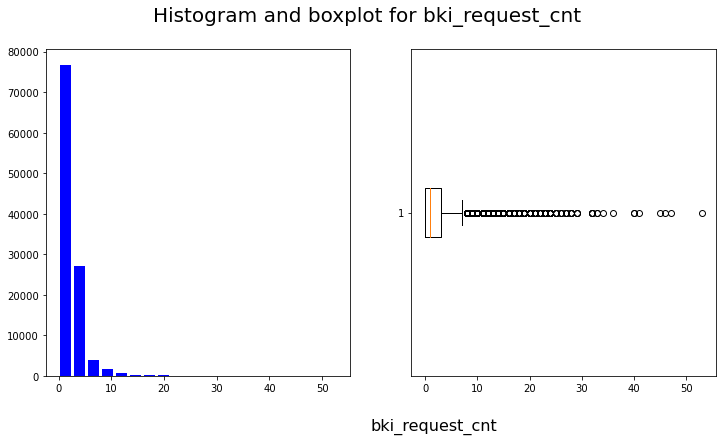

In [42]:
viz_num('bki_request_cnt')

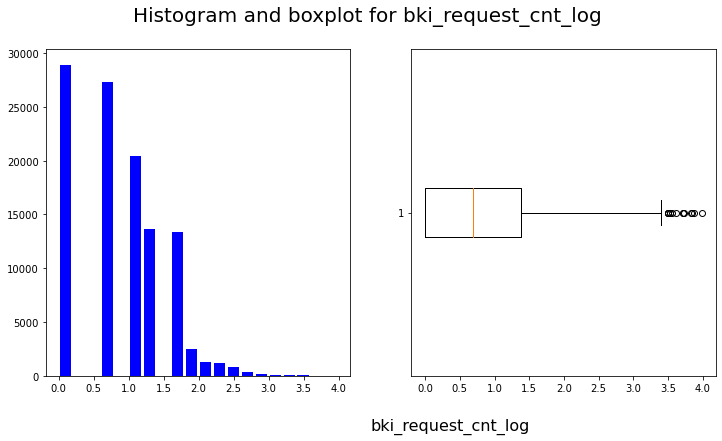

In [43]:
data['bki_request_cnt_log'] = np.log(data['bki_request_cnt'] + 1)
viz_num('bki_request_cnt_log')

In [44]:
statistic('bki_request_cnt')
statistic('bki_request_cnt_log')

Для bki_request_cnt IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
Всего 2636 выбросов
Для bki_request_cnt_log IQR: 1.3862943611198906,  Границы выбросов: [-2.0794415416798357, 3.465735902799726].
Всего 15 выбросов


Стало явно лучше, оставляем логарифмированный признак

In [45]:
data['bki_request_cnt'] = data['bki_request_cnt_log']
data.drop(['bki_request_cnt_log'],axis=1, inplace=True)

**income**

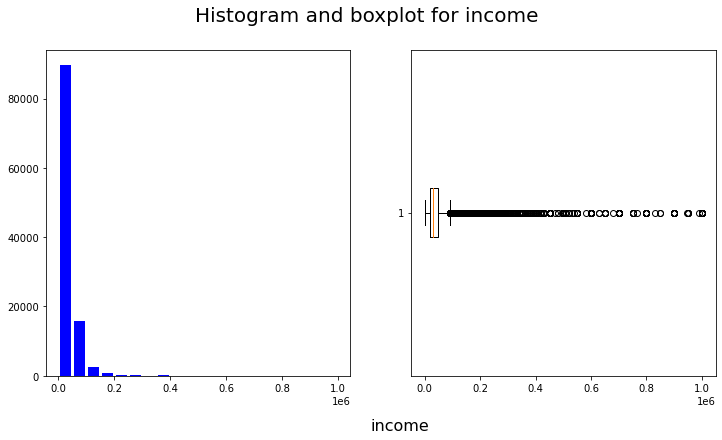

In [46]:
viz_num('income')

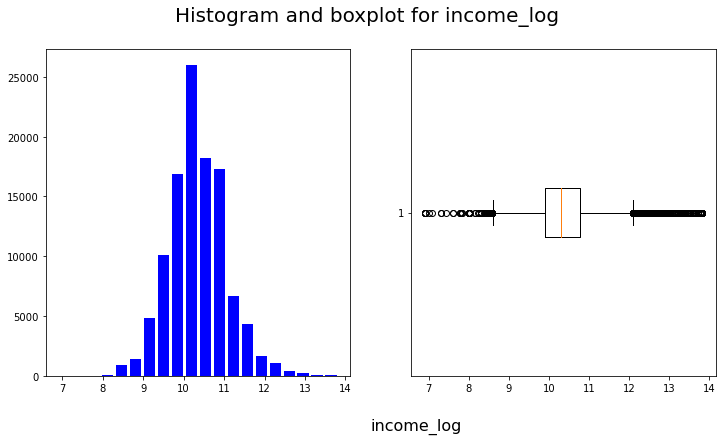

In [47]:
data['income_log'] = np.log(data['income'] + 1)
viz_num('income_log')

In [48]:
statistic('income')
statistic('income_log')

Для income IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
Всего 7000 выбросов
Для income_log IQR: 0.8754395717201806,  Границы выбросов: [8.590378193705899, 12.092136480586621].
Всего 2609 выбросов


Оставляем логарифмированный вариант

In [49]:
data['income'] = data['income_log']
data.drop(['income_log'], axis=1, inplace = True)

**delta_time**

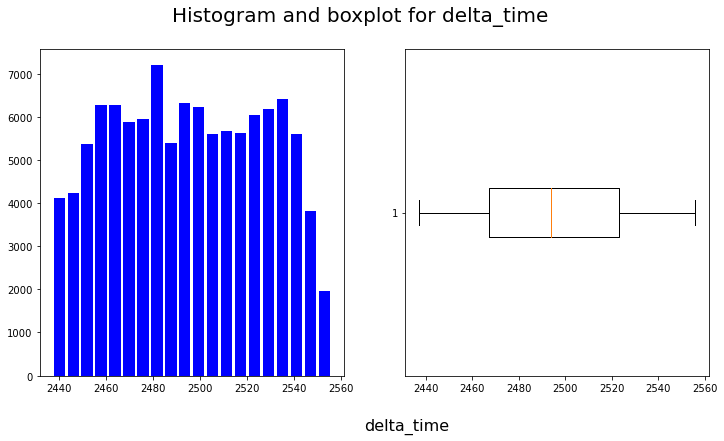

In [50]:
viz_num('delta_time')

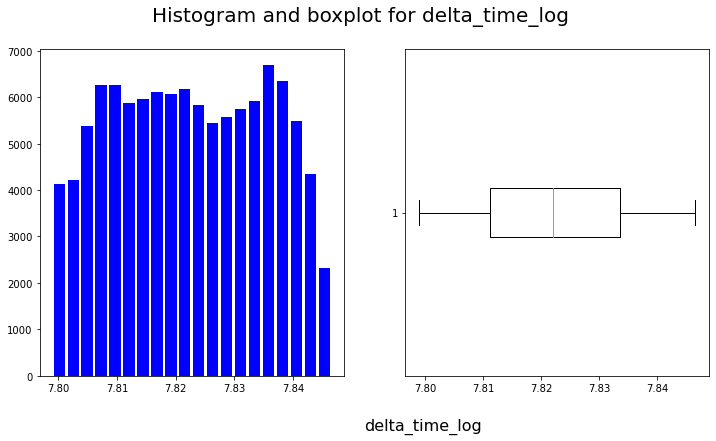

In [51]:
data['delta_time_log'] = np.log(data['delta_time'] + 1)
viz_num('delta_time_log')

In [52]:
statistic('delta_time')
statistic('delta_time_log')

Для delta_time IQR: 56.0,  Границы выбросов: [2383.0, 2607.0].
Всего 0 выбросов
Для delta_time_log IQR: 0.022436838635824685,  Границы выбросов: [7.777508127071542, 7.867255481614841].
Всего 0 выбросов


Ничего особо не поменялось, оставляем как было

In [53]:
data.drop(['delta_time_log'], axis=1, inplace=True)

In [54]:
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,Train,delta_time,day_num,decline_yes
0,25905,3,1,4.143135,1,1,0.000000,0,1.615833,0.693147,...,2,9.798183,4,1,0,0.0,1,2525,31,0
1,63161,3,0,4.094345,0,0,0.000000,0,2.092310,1.386294,...,3,9.852247,4,1,0,0.0,1,2486,70,0
2,25887,3,1,3.258097,1,0,1.098612,0,2.216444,0.693147,...,2,10.308986,1,4,1,0.0,1,2525,31,1
3,16222,3,0,3.988984,0,0,0.000000,0,1.567115,1.098612,...,3,9.210440,1,3,0,0.0,1,2534,22,0
4,101655,1,1,3.891820,0,0,0.000000,1,2.379864,0.693147,...,3,10.308986,1,4,1,0.0,1,2449,107,0


**day_num**

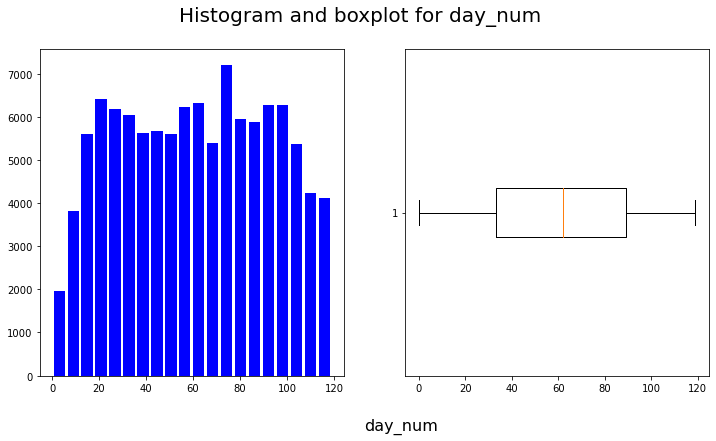

In [55]:
viz_num('day_num')

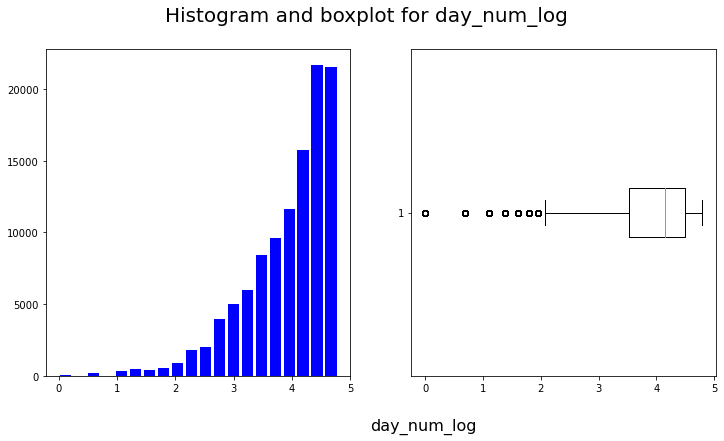

In [56]:
data['day_num_log'] = np.log(data['day_num'] + 1)
viz_num('day_num_log')

Cтало хуже, оставляем как было

In [57]:
data.drop(['day_num_log'], axis=1, inplace=True)

Посмотрим, что мы имеем в данный момент:

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  int64  
 2   sex               110148 non-null  int64  
 3   age               110148 non-null  float64
 4   car               110148 non-null  int64  
 5   car_type          110148 non-null  int64  
 6   decline_app_cnt   110148 non-null  float64
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  float64
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  float64
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

In [59]:
for i in data.columns:
    print(i)
    print(data[i].value_counts())

client_id
2047     1
97541    1
93447    1
70920    1
72969    1
        ..
47810    1
45763    1
35524    1
33477    1
2049     1
Name: client_id, Length: 110148, dtype: int64
education
3    58476
1    34768
4    14748
2     1865
0      291
Name: education, dtype: int64
sex
0    61836
1    48312
Name: sex, dtype: int64
age
3.465736    4084
3.433987    4035
3.367296    4035
3.332205    3964
3.401197    3940
3.295837    3780
3.496508    3773
3.555348    3548
3.526361    3499
3.583519    3386
3.258097    3292
3.610918    3228
3.637586    3185
3.688879    3095
3.663562    3070
3.713572    2950
3.761200    2857
3.737670    2804
3.218876    2780
3.784190    2672
3.806662    2536
3.178054    2295
3.828641    2235
3.931826    2104
3.850148    2102
3.891820    2084
3.871201    2074
3.970292    2065
3.951244    2015
3.988984    1980
3.912023    1964
4.007333    1911
4.025352    1837
4.043051    1641
4.060443    1578
3.135494    1415
4.077537    1373
4.094345    1340
3.091042    1262
4.110874   

**Посмотрим на корреляцию признаков**

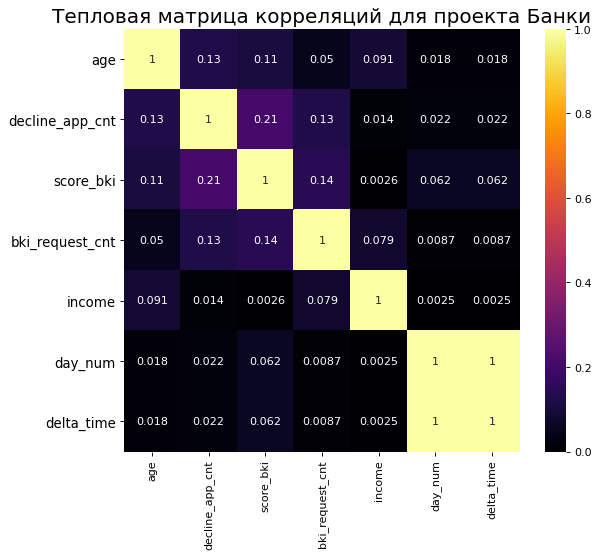

In [60]:
plt.figure(figsize=(8, 7), dpi= 80)
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, annot=True, cmap = 'inferno')

# Decorations
plt.title('Тепловая матрица корреляций для проекта Банки', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.show()

Видим, что созданные нами признаки полностью скоррелированы, значит один из них можно смело удалть

In [61]:
num_cols.remove('day_num')

In [62]:
data.drop(['day_num'], axis=1, inplace=True)


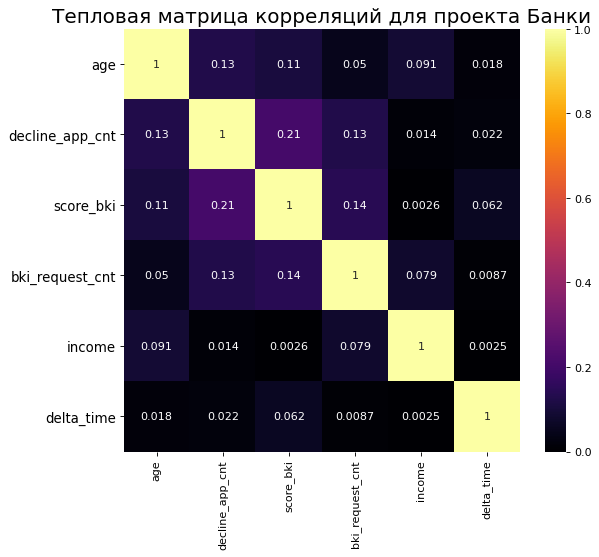

In [63]:
plt.figure(figsize=(8, 7), dpi= 80)
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, annot=True, cmap = 'inferno')

# Decorations
plt.title('Тепловая матрица корреляций для проекта Банки', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.show()

Сделаем общую корреляцию:

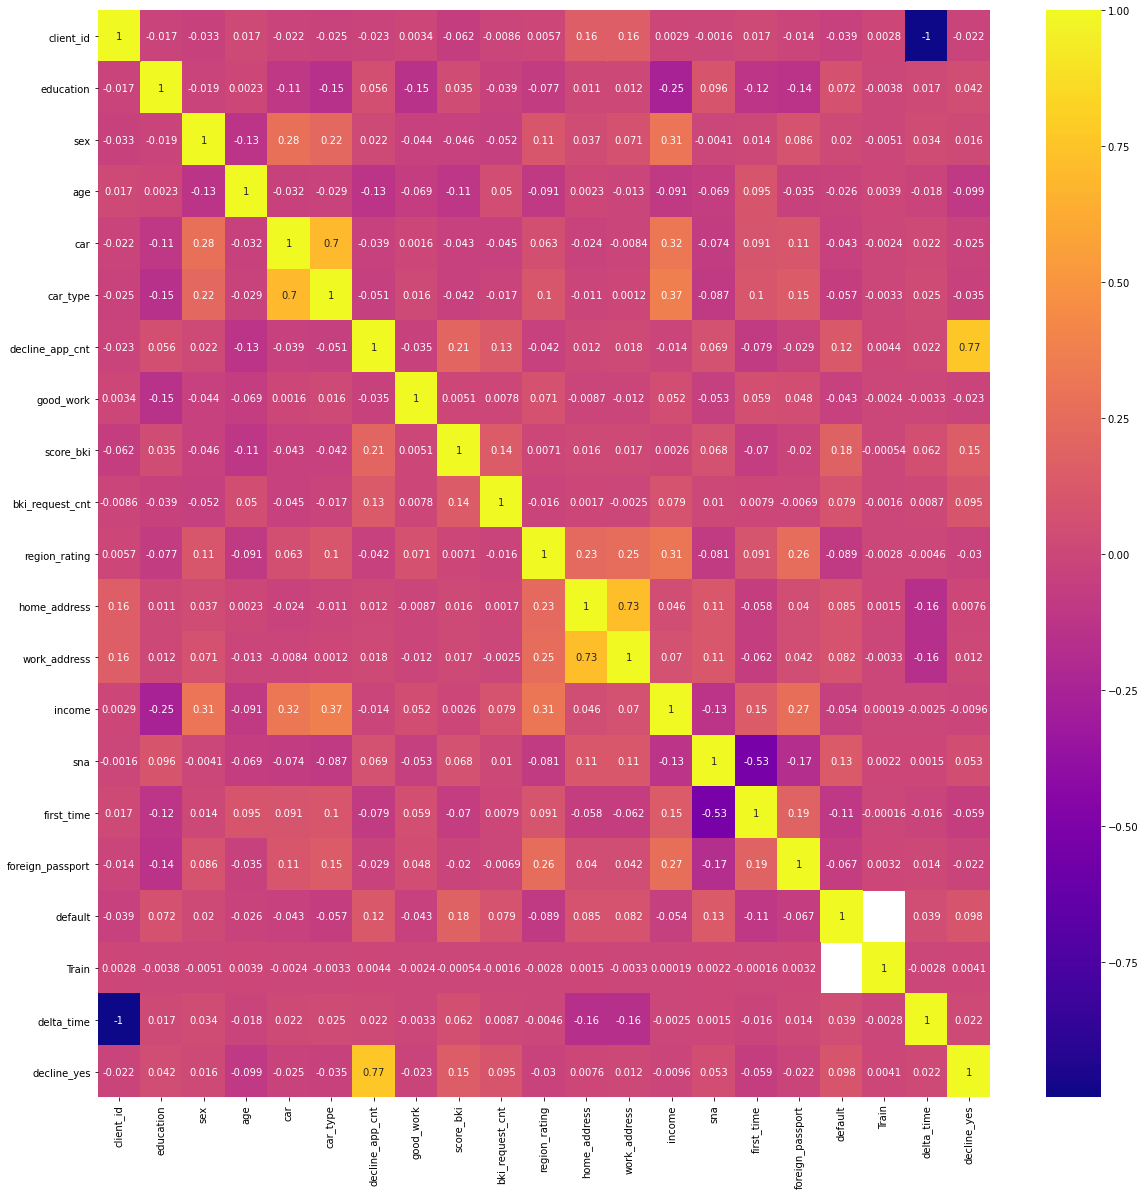

In [64]:
fig, ax = plt.subplots(1,1, figsize = (20,20))
ax = sns.heatmap(data.corr(),annot = True, cmap = 'plasma')

Проверим значимость непрерывных переменных (на основе однофакторного дисперсионного анализа (ANOVA)) Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

В качестве меры значимости мы будем использовать значение f -статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

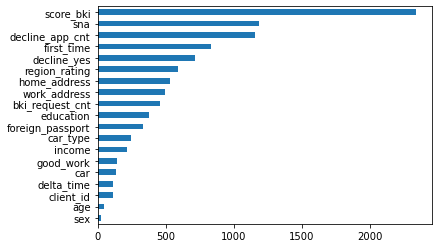

In [65]:
imp_num = Series(f_classif(data[data.Train == 1].drop(['Train', 'default'], axis = 1), data[data.Train == 1]['default'])[0], index = data.drop(['Train', 'default'], axis = 1).columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

самый значимый из числовых признаков score_bki , на втором месте sna, наименее значимый признак age

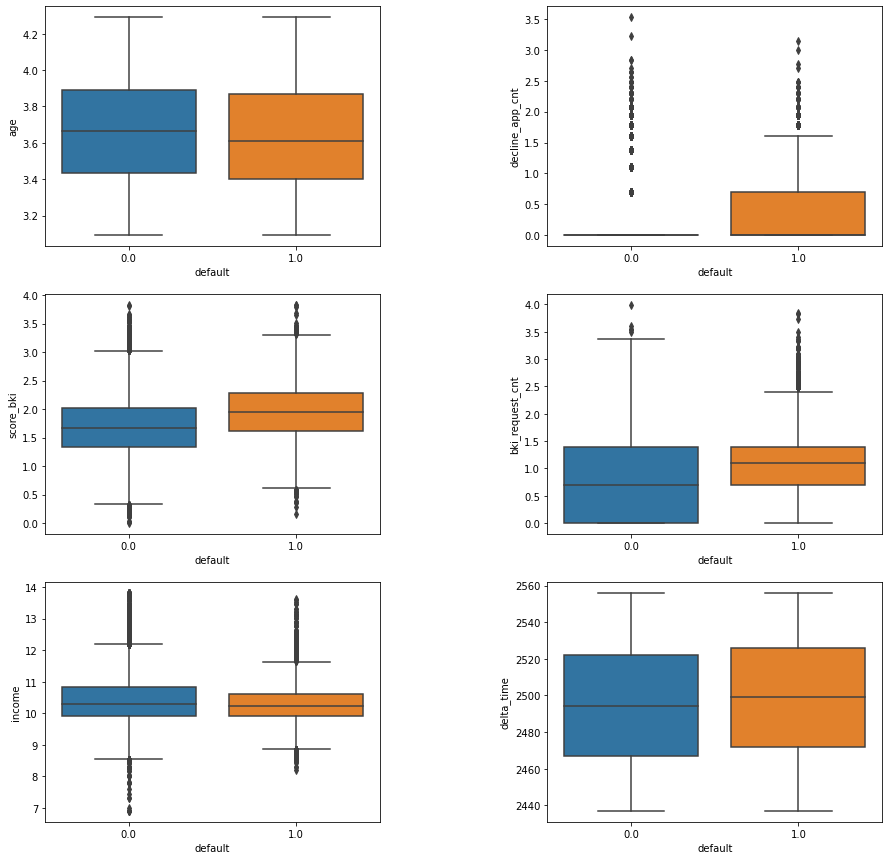

In [66]:
# Построим boxplot’ы для численных переменных
fig, axes = plt.subplots(3, 2, figsize=(15,15))
plt.subplots_adjust(wspace = 0.5)
axes = axes.flatten()

for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data=data[data.Train == 1], orient = 'v', ax=axes[i])

По боксплотам мы можем сделать много интересных выводов:

-средний возраст дефолтных клиентов ниже, чем у не дефолтны,

-количество отказанных прошлых заявок выше для для дефолтных клиентов,

-скоринговый балл по данным из БКИ выше для дефолтных,

-количество запросов в БКИ для дефолтных значительно больше,

-доход для дефолтных меньше,

-дефолтные клиенты в среднем дальше от сегодняшнего дня.

**Категориальные признаки**

Самое время использовать get dummies

In [67]:
data_cat = pd.get_dummies(data.loc[:, cat_cols], columns = cat_cols)
data_cat.sample(5)

,education_0,education_1,education_2,education_3,education_4,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,...,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
32811,0,1,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1
44600,0,1,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1
27939,0,0,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,1
13223,0,0,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,1,0
75913,0,0,0,0,1,0,0,0,1,0,...,0,1,0,1,0,0,0,0,1,0


Удалим еще два признака

In [68]:
bin_cols.remove('decline_yes')
data = data.drop('decline_yes', axis = 1)


In [69]:
# стандартизиуем числовые признаки

data_num = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]), columns = num_cols)

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  int64  
 2   sex               110148 non-null  int64  
 3   age               110148 non-null  float64
 4   car               110148 non-null  int64  
 5   car_type          110148 non-null  int64  
 6   decline_app_cnt   110148 non-null  float64
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  float64
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  float64
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

# Подготовка к построению модели

In [71]:
# объединим все в один DF
data_end = pd.concat([data_num, data_cat, data[bin_cols], data['Train'], data['default']], axis = 1)

In [72]:
data_end.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 39 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   age               110148 non-null  float64
 1   decline_app_cnt   110148 non-null  float64
 2   score_bki         110148 non-null  float64
 3   bki_request_cnt   110148 non-null  float64
 4   income            110148 non-null  float64
 5   delta_time        110148 non-null  float64
 6   education_0       110148 non-null  uint8  
 7   education_1       110148 non-null  uint8  
 8   education_2       110148 non-null  uint8  
 9   education_3       110148 non-null  uint8  
 10  education_4       110148 non-null  uint8  
 11  region_rating_20  110148 non-null  uint8  
 12  region_rating_30  110148 non-null  uint8  
 13  region_rating_40  110148 non-null  uint8  
 14  region_rating_50  110148 non-null  uint8  
 15  region_rating_60  110148 non-null  uint8  
 16  region_rating_70  11

вот для чего мы так удобно разделили с помощью Train

In [73]:
data_standart_train = data_end[data_end.Train == 1]
data_standart_test = data_end[data_end.Train == 0]
data_standart_train = data_standart_train.drop('Train', axis = 1)
data_standart_test = data_standart_test.drop('Train', axis = 1)

In [74]:
X = data_standart_train.drop('default', axis = 1)
y = data_standart_train['default']
# Выделим из тренировочного датасета 20% на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Проверка
print(X.shape, X_train.shape, X_test.shape)

(73799, 37) (59039, 37) (14760, 37)


# Обучение модели

In [75]:
model = LogisticRegression(random_state=RANDOM_SEED)
model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=42)

In [76]:
# метрика для оценки модели

class MatrixModel(): 
    def __init__(self, model, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = model.predict(X_test)
        self.probs = model.predict_proba(X_test)[:,1]
    
    def roc_curve_plot(self):
        fpr, tpr, threshold = roc_curve(self.y_test, self.probs)
        roc_auc = roc_auc_score(self.y_test, self.probs)

        plt.figure()
        plt.plot([0, 1], label='Baseline', linestyle='--')
        plt.plot(fpr, tpr, label = 'Regression')
        plt.title('Logistic Regression ROC AUC = %0.10f' % roc_auc)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc = 'lower right')
        plt.show()
    
    def confusion_matrix_plot(self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.y_pred).ravel()
        cf_matrix = np.array([[tp,fp],[fn,tn]])
        group_names = ['TP','FP','FN','TN']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure()
        sns.heatmap(cf_matrix, annot=labels, annot_kws={"size": 20}, fmt='', cmap= 'spring', cbar = False, \
                 xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
        plt.title('Матрица ошибок для default')
        plt.show()
        
    def get_metrics(self):
        result = pd.Series({
            'accuracy' : accuracy_score(self.y_test, self.y_pred),
            'precision' : precision_score(self.y_test, self.y_pred),
            'recall' : recall_score(self.y_test, self.y_pred),
            'F1' : f1_score(self.y_test, self.y_pred),
            'ROC_AUC': roc_auc_score(self.y_test, self.probs) 
        })
        return result
    
    def recall_precision_plot(self):
        precisions, recalls, _ = precision_recall_curve(self.y_test, self.y_pred)
        ap = average_precision_score(self.y_test, self.y_pred)        
        
        plt.figure()
        
        plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
        plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='lime')
        plt.xlabel('Recall');
        plt.ylabel('Precision');
        plt.title('Recall-precision curve, площадь под кривой = %0.10f' % ap)
        plt.grid(True)

        plt.show()

In [77]:
model_1 = MatrixModel(model, X_test, y_test)

In [78]:
model_1.get_metrics()

accuracy     0.874729
precision    0.394231
recall       0.022441
F1           0.042465
ROC_AUC      0.744768
dtype: float64

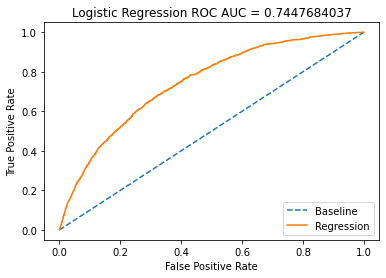

In [79]:
model_1.roc_curve_plot()

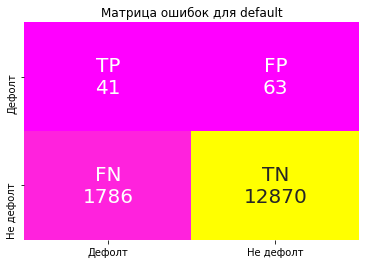

In [80]:
model_1.confusion_matrix_plot()

Хотя данные по Precision и Recall не  плохи, однако показатель F-меры и Accuracy низкий. Попробуем улучшить модель.

Добавим балансировку признаков и посмотрим, как это повлияет на модель.

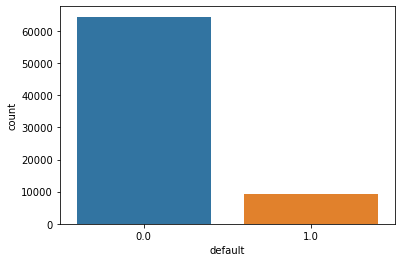

In [81]:
sns.countplot(x='default', data=data_standart_train)

In [82]:
print('класс 0: ', len(data_standart_train[data_standart_train.default == 0]))
print('класс 1: ', len(data_standart_train[data_standart_train.default == 1]))
print('веса классов: отношение дефолтных клиентов к недефолтным = {0}'.format(len(data_standart_train[data_standart_train.default == 0]) / len(data_standart_train[data_standart_train.default == 1])))

класс 0:  64427
класс 1:  9372
веса классов: отношение дефолтных клиентов к недефолтным = 6.874413145539906


Мы наблюдаем сильный перекос в сторону недефолтных клиентов, поэтому нам надо применить балансировку данных:

In [83]:
model = LogisticRegression(class_weight='balanced', random_state = RANDOM_SEED)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [84]:
model_2 = MatrixModel(model, X_test, y_test)
model_2.get_metrics()

accuracy     0.671070
precision    0.226715
recall       0.687466
F1           0.340980
ROC_AUC      0.744221
dtype: float64

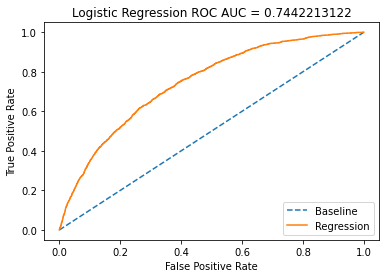

In [85]:
model_2.roc_curve_plot()

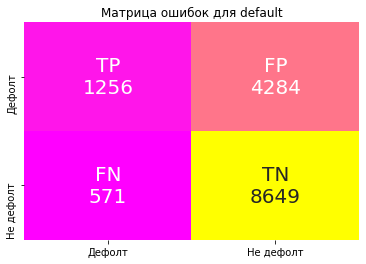

In [86]:
model_2.confusion_matrix_plot()

Несмотря на то, что упали результаты по Accuracy и Precision упали, значительно выросла F-мера и Recall. По сути модель стала присваивать большему количеству заявителей статус вероятного дефолта, чем улучшила итог, но в целом стала менее точна,что сказалось на значени ROC-AUC, которое немного понизилось. Попробуем поработать над данными.

Подберем параметры, согласно инструкции

In [87]:
from sklearn.model_selection import cross_validate

In [88]:
model = LogisticRegression(random_state = RANDOM_SEED)
iter_ = 50
epsilon_stop = 1e-3
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'lbfgs'
	tol: 0.001
	verbose: 0
	warm_start: False


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [89]:
model_3 = LogisticRegression(C = 1.0, class_weight = 'balanced', dual = False, fit_intercept = True,
                             intercept_scaling = 1, l1_ratio = None, max_iter = 50, multi_class = 'auto',
                             n_jobs = None, penalty = 'none', random_state = 42, solver = 'saga', tol = 0.001,
                             verbose = 0, warm_start = False)
model_3.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=50, penalty='none',
                   random_state=42, solver='saga', tol=0.001)

In [90]:
model_3 = MatrixModel(model, X_test, y_test)
model_3.get_metrics()

accuracy     0.670799
precision    0.226551
recall       0.687466
F1           0.340795
ROC_AUC      0.744209
dtype: float64

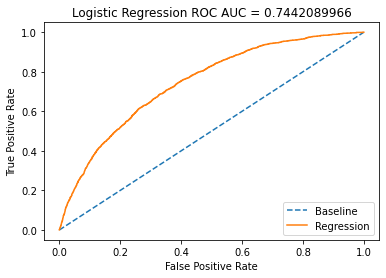

In [91]:
model_3.roc_curve_plot()

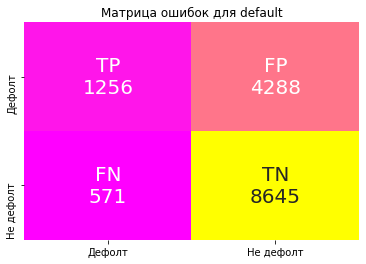

In [92]:
model_3.confusion_matrix_plot()

# Вывод
Благодоря подблору параметров удалось улучшить recall, f1 и precision. Ошибка второго рода сократилась , при этом увеличилась ошибка 1 рода, которая не несет явных экономических затрат, но увеличивает не явные. На метрику ROC_AUC подбор параметров повлиял не сильно.

# Submission

In [93]:
clf = LogisticRegression(C = 1.0, class_weight = 'balanced', dual = False, fit_intercept = True,
                             intercept_scaling = 1, l1_ratio = None, max_iter = 50, multi_class = 'auto',
                             n_jobs = None, penalty = 'none', random_state = 42, solver = 'saga', tol = 0.001,
                             verbose = 0, warm_start = False)

In [94]:
clf.fit(X, y)

LogisticRegression(class_weight='balanced', max_iter=50, penalty='none',
                   random_state=42, solver='saga', tol=0.001)

In [95]:
X_test = data_standart_test.drop(['default'], axis=1)
y_pred_prob = clf.predict_proba(X_test)[:,1]

submit = pd.DataFrame(data_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)

In [96]:
submit

,client_id,default
0,74835,0.201343
1,17527,0.793731
2,75683,0.306328
3,26883,0.408086
4,28862,0.135968
...,...,...
36344,83775,0.771015
36345,106254,0.110360
36346,81852,0.784280
36347,1971,0.627819
